In [1]:
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Standard imports
import numpy as np
import pandas as pd

# Matplotlib and Seaborn for visualizations
import matplotlib.pyplot as plt
plt.switch_backend('Agg')  # Ensure compatibility for backend usage
%matplotlib inline
import seaborn as sns

# Scikit-learn modules for predictive modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance

# Set plot aesthetics
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

Data Loading

In [3]:
df = pd.read_csv('bmw.csv',encoding='ascii',delimiter=',')
# Display first few rows of the dataframe
print('First 5 rows of the dataset:')
display(df.head())

# Basic DataFrame info
print('Dataset information:')
display(df.info())

# Check for missing values
print('Missing values per column:')
display(df.isnull().sum())


First 5 rows of the dataset:


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0


Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10781 entries, 0 to 10780
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         10781 non-null  object 
 1   year          10781 non-null  int64  
 2   price         10781 non-null  int64  
 3   transmission  10781 non-null  object 
 4   mileage       10781 non-null  int64  
 5   fuelType      10781 non-null  object 
 6   tax           10781 non-null  int64  
 7   mpg           10781 non-null  float64
 8   engineSize    10781 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 758.2+ KB


None

Missing values per column:


model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

Data Cleaning and Preprocessing

In [4]:
# Check for duplicates
print('Number of duplicate rows:', df.duplicated().sum())

# Drop duplicates if any
df = df.drop_duplicates()

# Since the dataset's columns are correctly typed (as per the description),
# we ensure that numeric columns are of numeric type and categorical columns are of string type.
numeric_columns = ['year', 'price', 'mileage', 'tax', 'mpg', 'engineSize']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Clean string columns (remove extra spaces if any)
df['model'] = df['model'].astype(str).str.strip()
df['transmission'] = df['transmission'].astype(str).str.strip()
df['fuelType'] = df['fuelType'].astype(str).str.strip()

# Fill or drop missing values if necessary (here we drop rows with missing numeric values as a simple approach)
df = df.dropna()

print('Cleaned dataset information:')
display(df.info())

Number of duplicate rows: 117
Cleaned dataset information:
<class 'pandas.core.frame.DataFrame'>
Index: 10664 entries, 0 to 10780
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         10664 non-null  object 
 1   year          10664 non-null  int64  
 2   price         10664 non-null  int64  
 3   transmission  10664 non-null  object 
 4   mileage       10664 non-null  int64  
 5   fuelType      10664 non-null  object 
 6   tax           10664 non-null  int64  
 7   mpg           10664 non-null  float64
 8   engineSize    10664 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 833.1+ KB


None

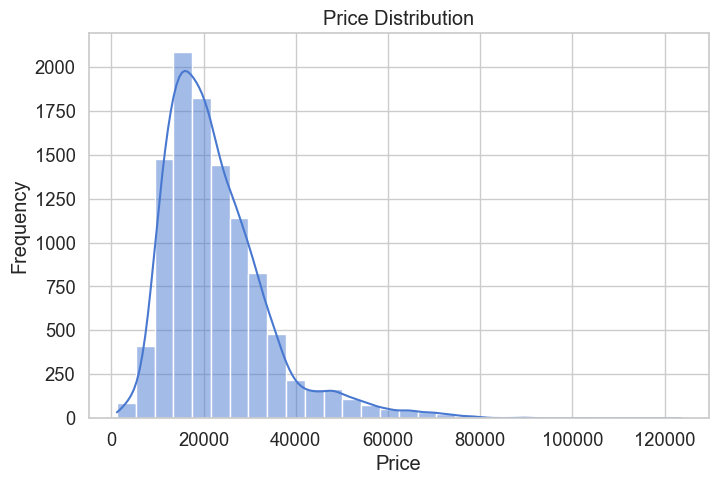

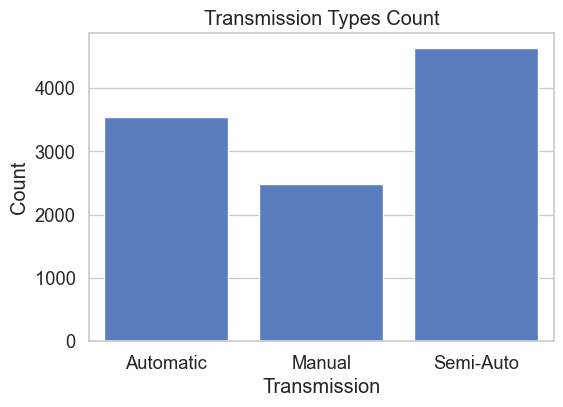

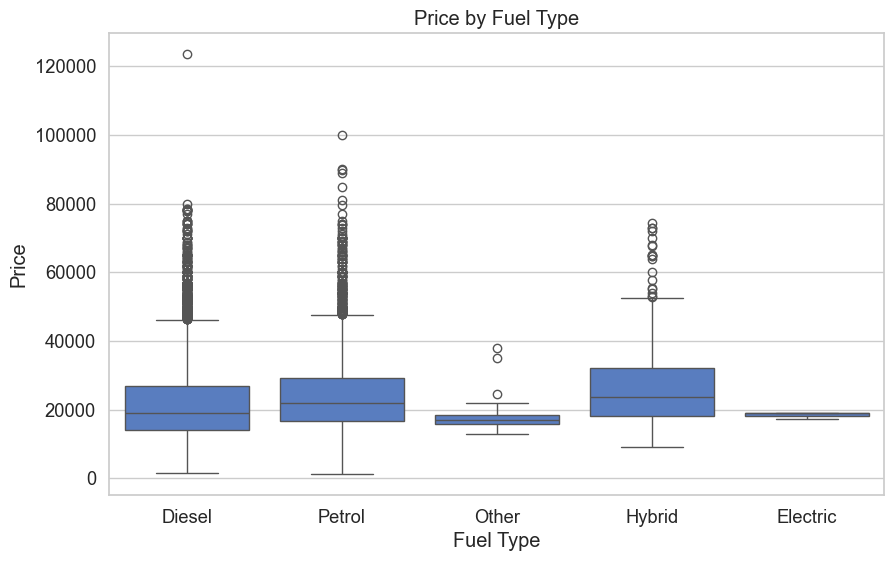

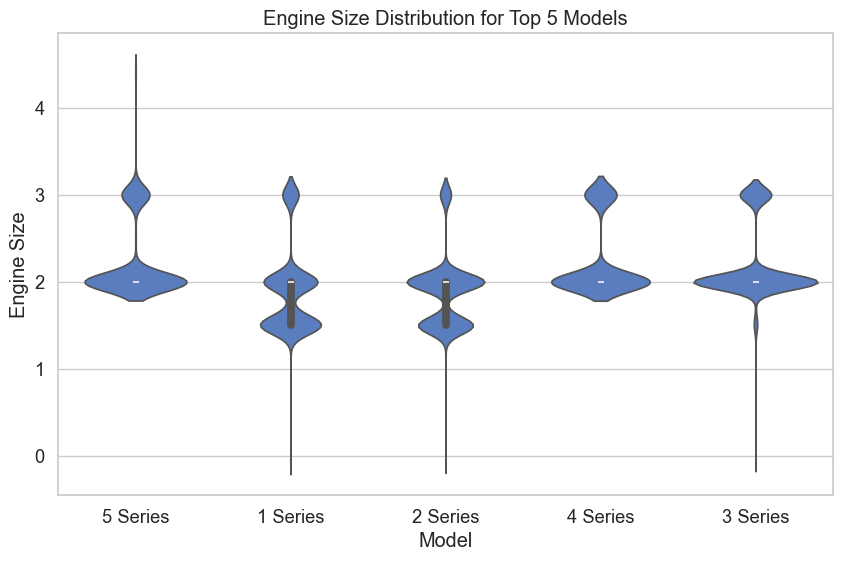

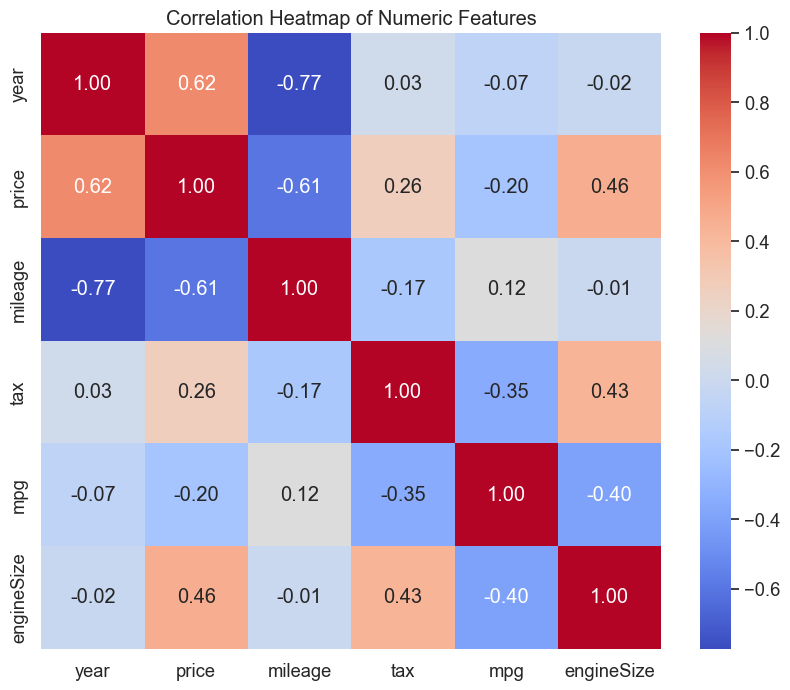

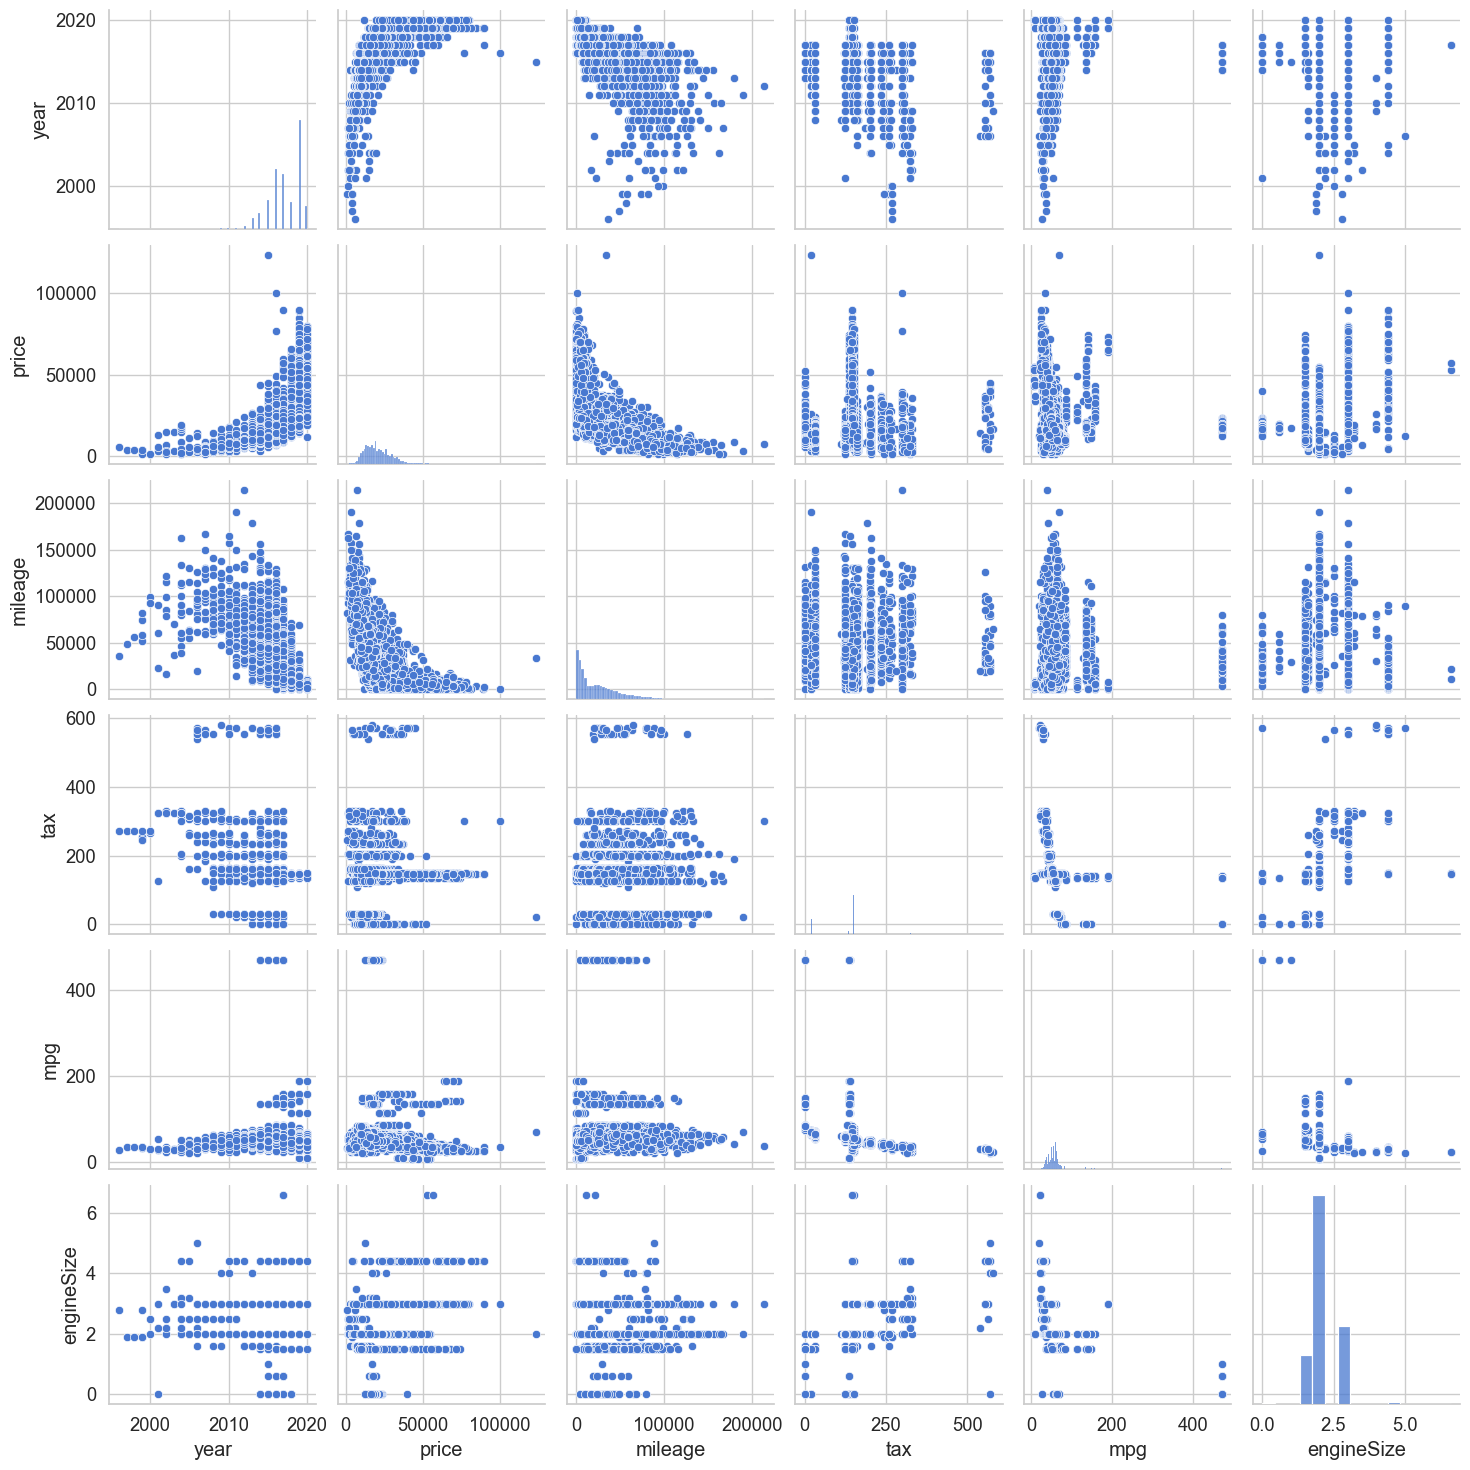

In [5]:
# Let's take a look at the distribution of some key variables

# Histogram for Price
plt.figure(figsize=(8, 5))
sns.histplot(df['price'], kde=True, bins=30)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# Countplot for Transmission types
plt.figure(figsize=(6, 4))
sns.countplot(x='transmission', data=df)
plt.title('Transmission Types Count')
plt.xlabel('Transmission')
plt.ylabel('Count')
plt.show()

# Box Plot for Price by Fuel Type
plt.figure(figsize=(10, 6))
sns.boxplot(x='fuelType', y='price', data=df)
plt.title('Price by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Price')
plt.show()

# Violin Plot for Engine Size by Model (if many models, results might be cluttered; consider top models only)
top_models = df['model'].value_counts().nlargest(5).index
plt.figure(figsize=(10, 6))
sns.violinplot(x='model', y='engineSize', data=df[df['model'].isin(top_models)])
plt.title('Engine Size Distribution for Top 5 Models')
plt.xlabel('Model')
plt.ylabel('Engine Size')
plt.show()

# For correlation, we only consider numeric columns
numeric_df = df.select_dtypes(include=[np.number])
if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(10, 8))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.show()

# Pair Plot for numeric features (limited to avoid overcrowding)
sns.pairplot(numeric_df)
plt.show()

Predictive Modeling

Random Forest R2 Score: 0.942
Random Forest Mean Absolute Error: 1554.723


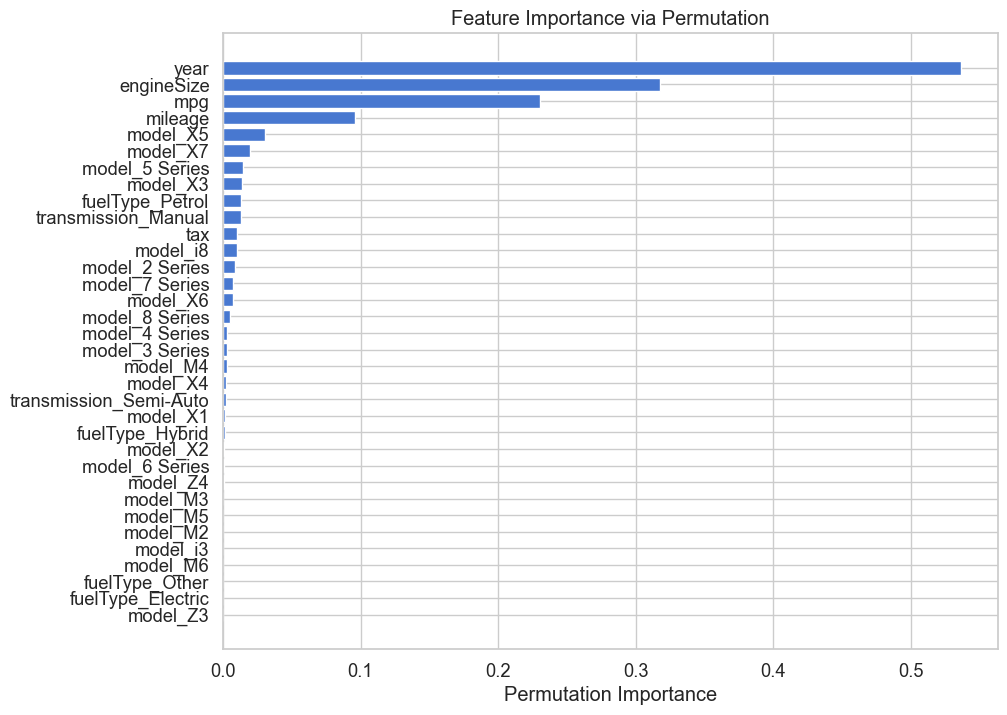

In [6]:
# In this section we will create a predictor to forecast the price of a BMW based on available features.
# For simplicity, we use a RandomForestRegressor which can handle both numeric and encoded categorical variables.

# Prepare features and target variable
target = 'price'
feature_cols = ['year', 'mileage', 'tax', 'mpg', 'engineSize']

# For the categorical features, we convert them using one-hot encoding and drop the first category to avoid collinearity issues
categorical_features = ['model', 'transmission', 'fuelType']
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# Combine numeric features with encoded categorical features (ensure price is not in features)
feature_cols_extended = [col for col in df_encoded.columns if col != target]

# Split the data into train and test sets
X = df_encoded[feature_cols_extended]
y = df_encoded[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate the model on the test set
y_pred = rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Random Forest R2 Score: {r2:.3f}')
print(f'Random Forest Mean Absolute Error: {mae:.3f}')

# Permutation importance to evaluate feature impact
perm_importance = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance via Permutation')
plt.show()